In [12]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

protocol.draw()

░      ┌───┐ ░    ┌─┐ ░                         
Q: ───────────░───■──┤ H ├─░────┤M├─░─────────────────────────
   ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░                         
A: ┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─────────────────────────
   └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ ┌──────────┐┌──────────┐
B: ─────┤ X ├─░────────────░──╫──╫──░─┤0         ├┤0         ├
        └───┘ ░            ░  ║  ║  ░ │  If_else ││          │
a: ═══════════════════════════╩══╬════╡0         ╞╡          ╞
                                 ║    └──────────┘│          │
b: ══════════════════════════════╩════════════════╡0         ╞
                                                  └──────────┘

In [13]:
from qiskit.circuit.library import UGate
from numpy import pi, random

random_gate = UGate(
    theta = random.random()*2*pi,
    phi  = random.random()*2*pi,
    lam = random.random()*2*pi
)

display(random_gate.to_matrix())

array([[-0.24093981+0.j        ,  0.89064343+0.38561936j],
       [ 0.07756824-0.96743536j,  0.11309639-0.21274679j]])

In [14]:
#New circuit using the same bits and qubits used in teleportation protocol

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

#Starting with randomly selected gate on Q

test.append(random_gate, qubit)
test.barrier()

#Append the teleportation from above code
test = test.compose(protocol)
test.barrier()

#Apply inverse of random unit to B and measure
test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

test.draw()

┌─────────────────────────┐ ░            ░      ┌───┐ ░    ┌─┐ ░ »
     Q: ┤ U(3.6283,4.7924,3.5502) ├─░────────────░───■──┤ H ├─░────┤M├─░─»
        └─────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░ »
     A: ────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─»
                                    ░ └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ »
     B: ────────────────────────────░──────┤ X ├─░────────────░──╫──╫──░─»
                                    ░      └───┘ ░            ░  ║  ║  ░ »
     a: ═════════════════════════════════════════════════════════╩══╬════»
                                                                    ║    »
     b: ════════════════════════════════════════════════════════════╩════»
                                                                         »
Result: ═════════════════════════════════════════════════════════════════»
                                                                         »
«                                 ░                                  
«     Q: ─────────────────────────░──────────────────────────────────
«                                 ░                                  
«     A: ─────────────────────────░──────────────────────────────────
«        ┌──────────┐┌──────────┐ ░ ┌────────────────────────────┐┌─┐
«     B: ┤0         ├┤0         ├─░─┤ U(-3.6283,-3.5502,-4.7924) ├┤M├
«        │  If_else ││          │ ░ └────────────────────────────┘└╥┘
«     a: ╡0         ╞╡          ╞══════════════════════════════════╬═
«        └──────────┘│          │                                  ║ 
«     b: ════════════╡0         ╞══════════════════════════════════╬═
«                    └──────────┘                                  ║ 
«Result: ══════════════════════════════════════════════════════════╩═
«

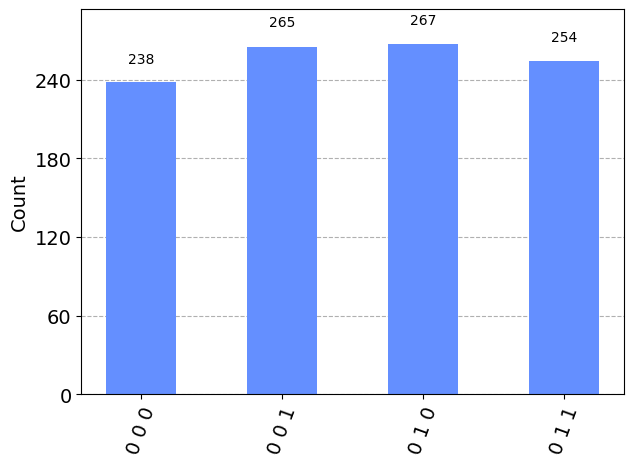

In [15]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

result = AerSimulator().run(test).result()
statistics = result.get_counts()
plot_histogram(statistics)

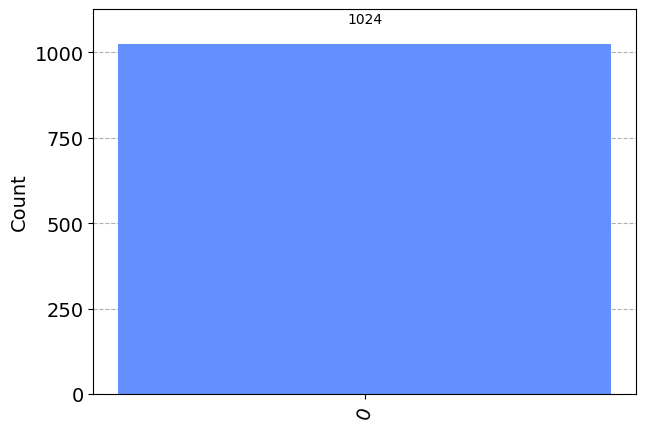

In [16]:
from qiskit.result import marginal_distribution

filtered_statistics = marginal_distribution(statistics, [2])
plot_histogram(filtered_statistics)